In [61]:
import networkx as nx
import osmnx as ox
from matplotlib import pyplot as plt

import utils

In [62]:
data_path = "./data"

## Fetch OSMnx graph
road_graph_ox = ox.graph_from_bbox(bbox=(113.95088, 22.57502, 114.08323, 22.71175), network_type="drive",
                                   simplify=False)
print("Road Graph OSMnx:")
print(road_graph_ox)

road_graph_ox = ox.add_edge_speeds(road_graph_ox)
road_graph_ox = ox.add_edge_travel_times(road_graph_ox)

# Remove self-loops
road_graph_ox.remove_edges_from(nx.selfloop_edges(road_graph_ox))

# Save OSMnx road graph
ox.save_graphml(road_graph_ox, filepath=f"{data_path}/road_graph_ox_nsl.xml", encoding="utf-8")
# road_graph_ox = ox.load_graphml(filepath=f"{data_path}/road_graph_ox_nsl.xml")
print("Road Graph OSMnx (nsl):")
print(road_graph_ox)

road_graph_ox = ox.project_graph(road_graph_ox, to_crs=utils.EPSG_32650)

tolerance = 35
road_graph_ox = ox.simplify_graph(road_graph_ox, track_merged=True)
road_graph_ox = ox.consolidate_intersections(road_graph_ox, tolerance=tolerance, rebuild_graph=True, dead_ends=True,
                                             reconnect_edges=True)

road_graph_ox = ox.project_graph(road_graph_ox, to_crs=utils.EPSG_4326)
ox.save_graphml(road_graph_ox, filepath=f"{data_path}/road_graph_ox_sim_con_{tolerance}_nsl.xml", encoding="utf-8")
print("Road Graph OSMnx (nsl, sim, con):")
print(road_graph_ox)

sccs = nx.strongly_connected_components(road_graph_ox)
max_scc = max(sccs, key=len)
max_scc_sub_road_graph = road_graph_ox.subgraph(max_scc).copy()

print("Road Graph OSMnx (nsl, sim, con, sc):")
print(max_scc_sub_road_graph)

ox.save_graphml(max_scc_sub_road_graph, filepath=f"{data_path}/road_graph_ox_sim_con_{tolerance}_nsl_sc.xml",
                encoding="utf-8")

Road Graph OSMnx:
MultiDiGraph with 41456 nodes and 58920 edges
Road Graph OSMnx (nsl):
MultiDiGraph with 41456 nodes and 58920 edges
Road Graph OSMnx (nsl, sim, con):
MultiDiGraph with 2609 nodes and 6476 edges
Road Graph OSMnx (nsl, sim, con, sc):
MultiDiGraph with 2435 nodes and 6210 edges


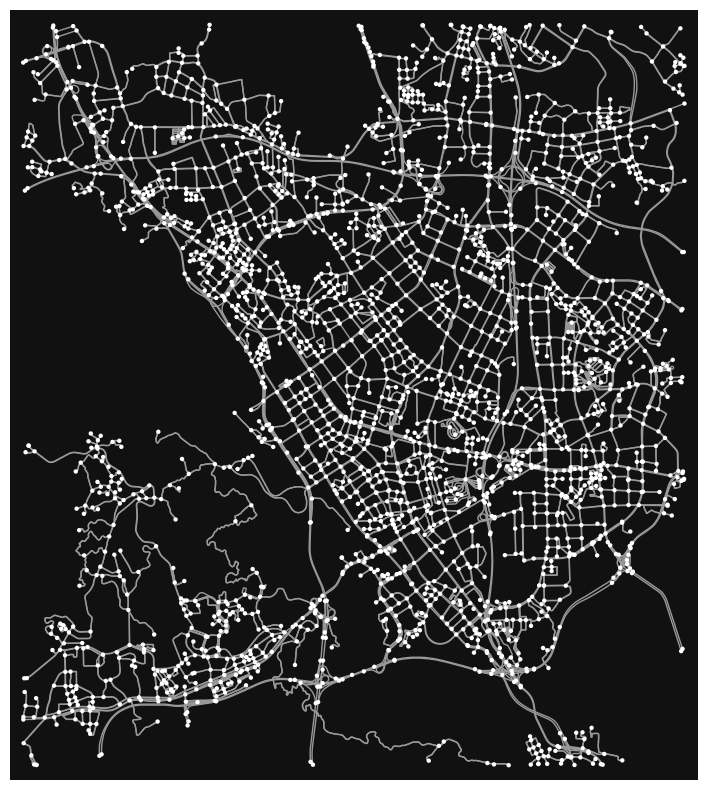

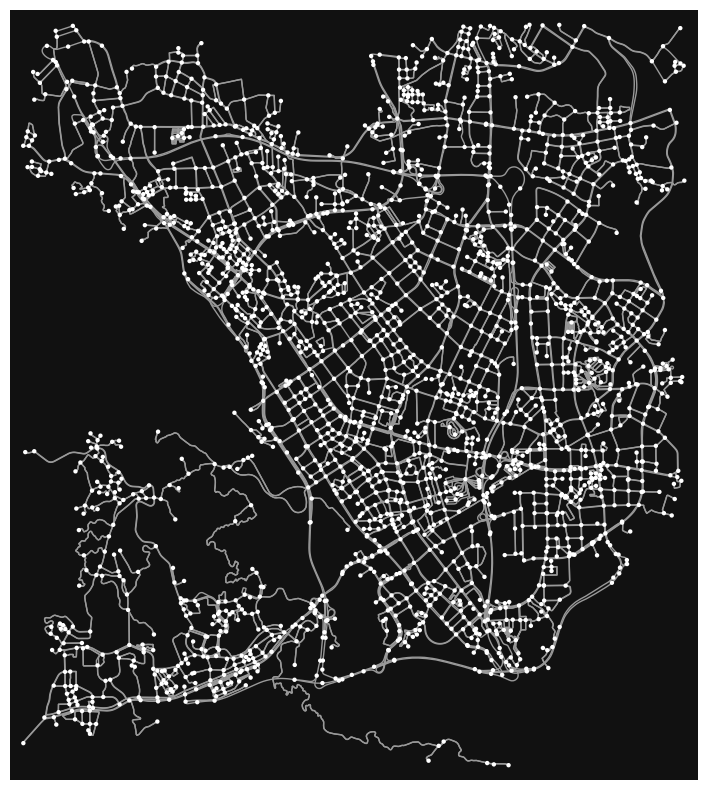

In [63]:
## Draw the road graph
pos = {node: (road_graph_ox.nodes[node]["x"], road_graph_ox.nodes[node]["y"]) for node in road_graph_ox.nodes()}

fig, ax = ox.plot_graph(
    road_graph_ox,
    node_size=10,
    figsize=(10, 10)
)
ax.set_title("Road Graph OSMnx (nsl, sim, con)")

fig, ax = ox.plot_graph(
    max_scc_sub_road_graph,
    node_size=10,
    figsize=(10, 10)
)
ax.set_title("Road Graph OSMnx (nsl, sim, con, sc)")

plt.show()